# Определение перспективного тарифа для телеком-компании

## Описание проекта

Проведём аналитику для компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

**Тариф «Смарт»**

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей
        
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## План работы

[Часть 1. Откроем файлы с данными и изучим общую информацию.](#step1)

[Часть 2. Подготовим данные.](#step2)

    Приведём данные к нужным типам;
    Найдём и исправим ошибки в данных, если они есть.

Посчитаем для каждого пользователя:

    количество сделанных звонков и израсходованных минут разговора по месяцам;
    количество отправленных сообщений по месяцам;
    объем израсходованного интернет-трафика по месяцам;
    помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

[Часть 3. Проанализируем данные.](#step3)

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

[Часть 4. Проверим гипотезы.](#step4)

    средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

[Часть 5. Заключение.](#step5)

## Описание данных

Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tarif — название тарифного плана

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Часть 1. Откроем файлы с данными и изучим общую информацию.<a id="step1"></a>

Импортируем библиотеки.

In [19]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

Откроем таблицы и изучим общую информацию.

In [20]:
if os.path.exists('users.csv'):
    df_users = pd.read_csv('users.csv')
else:
    df_users = pd.read_csv('/datasets/users.csv')

df_users.info()
display(df_users.head())
df_users.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


In [21]:
if os.path.exists('calls.csv'): # проверка валидности пути к датасету при работе локально и с портала
    df_calls = pd.read_csv('calls.csv')
else:
    df_calls = pd.read_csv('/datasets/calls.csv')

df_calls.info()
display(df_calls.head())
df_calls.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


In [22]:
if os.path.exists('messages.csv'):
    df_messages = pd.read_csv('messages.csv')
else:
    df_messages = pd.read_csv('/datasets/messages.csv')

df_messages.info()
display(df_messages.head())
df_messages.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


In [23]:
if os.path.exists('internet.csv'):
    df_internet = pd.read_csv('internet.csv')
else:
    df_internet = pd.read_csv('/datasets/internet.csv')

df_internet.info()
display(df_internet.head())
df_internet.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


In [24]:
if os.path.exists('tariffs.csv'):
    df_tariffs = pd.read_csv('tariffs.csv')
else:
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')

df_tariffs.info()
display(df_tariffs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод

Данные в хорошем состоянии, все названия, кроме одного, в "змеином регистре". Выбивающихся или аномальных значений незаметно. Пропуски есть только в таблице `users.csv` в столбце `churn_date`, но из описания данных мы знаем что если в данном столбце нет данных, то тариф всё ещё действует. Испаравлять это нет необходимости.

Единственный столбец вызывающий вопросы есть в таблице `internet.csv`: `Unnamed: 0`. В описании данных его нет, судя по значениям это продублированные номера строк.

## Часть 2. Подготовка данных. <a id="step2"></a>

Проверим предположение что столбец `Unnamed: 0` является дубликатом индекса.

In [25]:
df_internet[df_internet.index == df_internet['Unnamed: 0']].shape[0]

149396

Предположение подтвердилось, возможно неверный SQL запрос в базу данных. Удалим данный столбец.

In [26]:
df_internet.drop(columns = 'Unnamed: 0', inplace = True)

Приведём даты к формату datetime.

In [27]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

Посчитаем для каждого пользователя:

    количество сделанных звонков и израсходованных минут разговора по месяцам;
    количество отправленных сообщений по месяцам;
    объем израсходованного интернет-трафика по месяцам;
    помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).
    
Добавим в таблицу `calls` столбец с месяцами, а также проведём округление длительности звонков до целых минут вверх, как указано в условии использования тарифов.

In [28]:
df_calls['month'] = df_calls['call_date'].astype('datetime64[M]')
df_calls['duration'] = np.ceil(df_calls['duration'])

df_calls_grouped = df_calls.groupby(['user_id', 'month']).agg(
    calls_duration = ('duration', 'sum'),
    calls_count = ('duration', 'count')
)

Теперь посчитаем данные по количеству сообщений.

In [29]:
df_messages['month'] = df_messages['message_date'].astype('datetime64[M]')

df_messages_grouped = df_messages.groupby(['user_id', 'month']).agg(
    messages_count = ('id', 'count')
)

Добавим объём израсходованного трафика по месяцам, округляя до Гб в большую сторону.

In [30]:
df_internet['month'] = df_internet['session_date'].astype('datetime64[M]')

df_internet_grouped = df_internet.groupby(['user_id', 'month']).agg(
    traffic_sum = ('mb_used', 'sum')
)

In [31]:
df_internet_grouped

traffic_sum
user_id month                  
1000    2018-05-01      2253.49
        2018-06-01     23233.77
        2018-07-01     14003.64
        2018-08-01     14055.93
        2018-09-01     14568.91
...                         ...
1498    2018-10-01     20579.36
1499    2018-09-01      1845.75
        2018-10-01     17788.51
        2018-11-01     17963.31
        2018-12-01     13055.58

[3203 rows x 1 columns]

Так как разные пользователи могли не пользоваться какими-то услугами, то сначала объединим статистику по использованию услуг в отдельную группу.

In [13]:
statistic = df_internet_grouped\
    .merge(df_calls_grouped, how='outer', on=['user_id', 'month'])\
    .merge(df_messages_grouped, how='outer', on=['user_id', 'month'])
statistic.reset_index(level='month', inplace=True)

Теперь добавим статистическую информацию к общей инофрмации о пользователях.

In [14]:
df = df_users.merge(statistic, how='outer', on='user_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   age             3216 non-null   int64         
 2   churn_date      189 non-null    datetime64[ns]
 3   city            3216 non-null   object        
 4   first_name      3216 non-null   object        
 5   last_name       3216 non-null   object        
 6   reg_date        3216 non-null   datetime64[ns]
 7   tariff          3216 non-null   object        
 8   month           3214 non-null   datetime64[ns]
 9   traffic_sum     3203 non-null   float64       
 10  calls_duration  3174 non-null   float64       
 11  calls_count     3174 non-null   float64       
 12  messages_count  2717 non-null   float64       
dtypes: datetime64[ns](3), float64(4), int64(2), object(4)
memory usage: 351.8+ KB


In [15]:
df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,traffic_sum,calls_duration,calls_count,messages_count
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,3.0,159.0,22.0,22.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,23.0,172.0,43.0,60.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,14.0,340.0,47.0,75.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,14.0,408.0,52.0,81.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,15.0,466.0,58.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018-10-01,21.0,247.0,41.0,42.0
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-09-01,2.0,70.0,9.0,11.0
3213,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-10-01,18.0,449.0,68.0,48.0
3214,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-11-01,18.0,612.0,74.0,59.0


Из общей таблицы видно что пользователи необязательно использовали все возможности тарифов, кто-то не звонил, кто-то не пользовался интернетом, больше всего пользователи игнорировали сообщения.

Интересно что информация о месяцах отсутствует для двух строк, проверим их.

In [15]:
df[df['month'] != df['month']]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,traffic_sum,calls_duration,calls_count,messages_count
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaT,NaN,NaN,NaN,NaN
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaT,NaN,NaN,NaN,NaN


Оба пользователя не пользовались никакими услугами и отказались от тарифов в течении месяца. Т.к. нас интересует сравнение использования пользователями двух тарифов, от этих двух строк можно избавиться.

In [16]:
df.drop(df[df['month'] != df['month']].index, inplace=True)

Наконец, добавим помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [32]:
def tariff_income(row):
    '''
    Функция вычисляет помесячную выручку на основе информации о тарифах.
    '''
    if row['tariff'] == 'smart':
        i = 0
    elif row['tariff'] == 'ultra':
        i = 1
    result = df_tariffs.at[i, 'rub_monthly_fee']
    if row['calls_duration'] > df_tariffs.at[i, 'minutes_included']:
        result += (row['calls_duration'] - df_tariffs.at[i, 'minutes_included']) * df_tariffs.at[i, 'rub_per_minute']
    if row['traffic_sum'] > df_tariffs.at[i, 'mb_per_month_included'] / 1024:
        result += (row['traffic_sum'] - df_tariffs.at[i, 'mb_per_month_included'] / 1024) * df_tariffs.at[i, 'rub_per_gb']
    if row['messages_count'] > df_tariffs.at[i, 'messages_included']:
        result += (row['messages_count'] - df_tariffs.at[i, 'messages_included']) * df_tariffs.at[i, 'rub_per_message']
    return result

In [33]:
df['income'] = df.apply(tariff_income, axis=1)
df.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,traffic_sum,calls_duration,calls_count,messages_count,income
1410,1221,40,NaT,Белгород,Джемма,Сафонова,2018-06-03,smart,2018-07-01,9.0,114.0,20.0,32.0,550.0
952,1150,58,NaT,Сургут,Майя,Муравьева,2018-08-05,ultra,2018-09-01,12.0,430.0,51.0,137.0,1950.0
700,1110,26,NaT,Петрозаводск,Матвей,Александрович,2018-05-06,smart,2018-06-01,25.0,363.0,48.0,29.0,2550.0
2930,1456,40,NaT,Санкт-Петербург,Мануэла,Андропова,2018-08-25,smart,2018-12-01,27.0,930.0,111.0,NaN,4240.0
1818,1286,19,NaT,Москва,Рашид,Троицкий,2018-11-27,smart,2018-11-01,5.0,47.0,9.0,12.0,550.0


In [34]:
df['income'] = df['income']*1000000

In [35]:

df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,traffic_sum,calls_duration,calls_count,messages_count,income
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,3.0,159.0,22.0,22.0,1.950000e+09
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,23.0,172.0,43.0,60.0,1.950000e+09
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,14.0,340.0,47.0,75.0,1.950000e+09
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,14.0,408.0,52.0,81.0,1.950000e+09
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,15.0,466.0,58.0,57.0,1.950000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018-10-01,21.0,247.0,41.0,42.0,1.750000e+09
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-09-01,2.0,70.0,9.0,11.0,5.500000e+08
3213,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-10-01,18.0,449.0,68.0,48.0,1.150000e+09
3214,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-11-01,18.0,612.0,74.0,59.0,1.513000e+09


### Вывод

Мы подготовили исходные таблицы, убрали лишние столбцы и заменили типы данных, там где это было необзодимо.

Посчитали для каждого пользователя:

    количество сделанных звонков и израсходованных минут разговора по месяцам;
    количество отправленных сообщений по месяцам;
    объем израсходованного интернет-трафика по месяцам;
    помесячную выручку с каждого пользователя.
    
Теперь можно приступать к анализу данных.

## Часть 3. Анализ данных.<a id="step3"></a>

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение.

In [19]:
df.pivot_table(
    index='tariff',
    values=['calls_duration', 'messages_count', 'traffic_sum', 'income'],
    aggfunc=['mean', 'var', 'std', 'median']
).round(decimals=2).transpose()

tariff                     smart      ultra
mean   calls_duration     419.06     545.45
       income            1289.97    2070.15
       messages_count      38.72      61.16
       traffic_sum         16.34      19.69
var    calls_duration   35844.19   94203.42
       income          669785.71  141516.75
       messages_count     717.59    2109.66
       traffic_sum         32.92      94.15
std    calls_duration     189.33     306.93
       income             818.40     376.19
       messages_count      26.79      45.93
       traffic_sum          5.74       9.70
median calls_duration     423.00     528.00
       income            1023.00    1950.00
       messages_count      34.00      51.00
       traffic_sum         17.00      19.00

По сводной таблице видно, что среднее количество звонков больше на тарифе `ultra`, также как и дисперсия со стандартным отклонением.

Средний доход почти в два раза выше на тарифе `ultra`, диспресия ниже более чем в 5 раз, стандартное отклонение также ниже в 2 раза.

Количество смс также существенно отличается, почти в 2 раза больше на тарифе `ultra`.

Средний траффик выше на тарифе `ultra`, дисперсия существенно выше в тарифе `ultra`.

Построим гистограммы.

In [20]:
def draw_hist(*args):
    '''
    Функция строит гистограммы для переданных колонок, разделяя данные по тарифам.
    '''
    for column in args:
        plt.figure(figsize=(15, 5))
        plt.title(column, pad = 15, size = 16)
        plt.xlabel(column, labelpad = 10, size = 12)
        plt.ylabel('Количество', labelpad = 10, size = 12)
        plt.hist(
            [df[df['tariff'] == 'smart'][column], df[df['tariff'] == 'ultra'][column]],
            bins=50, rwidth=1, label=['Smart', 'Ultra'], alpha=.75
        )
        
        plt.grid(which='both')
        plt.legend()
        plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


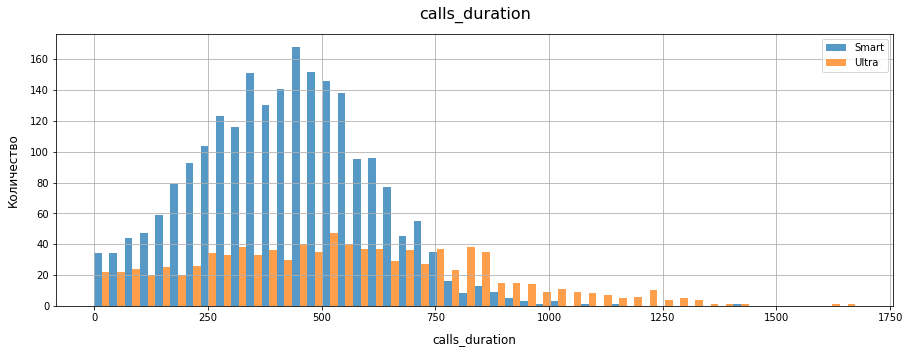

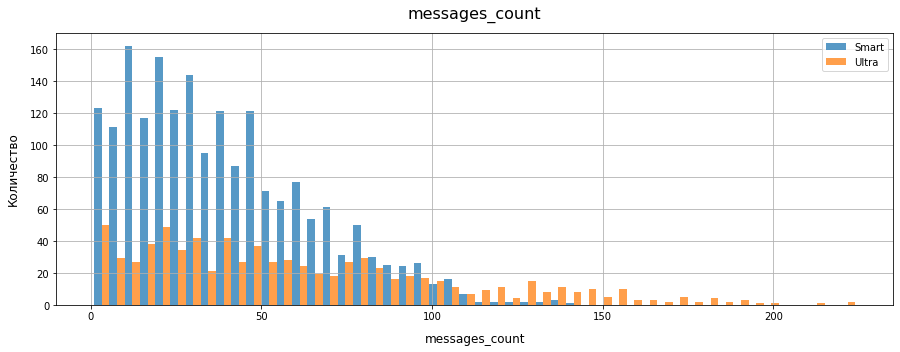

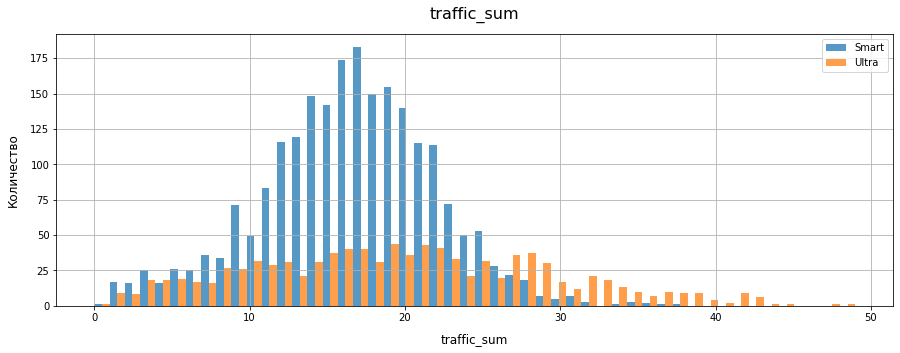

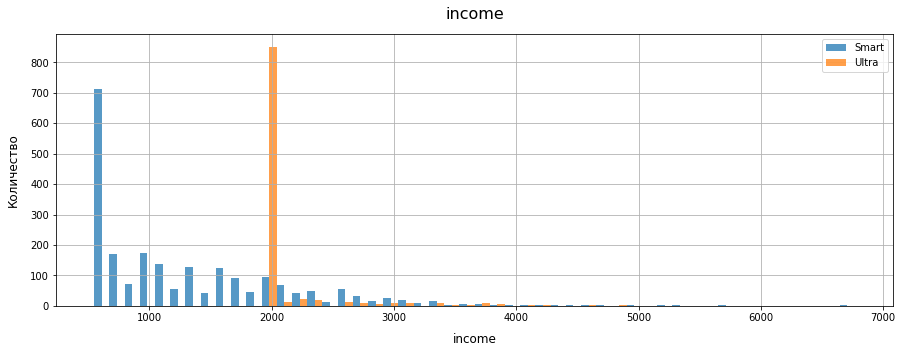

In [21]:
draw_hist('calls_duration', 'messages_count', 'traffic_sum', 'income')

### Вывод

Для тарифа `smart`:

    гистограмма длительности звонков для смещена влево, около 40% пользователей тратят минуты сверх включённых в тариф,
    гистограмма количества сообщений смещена вправо, значительное количество пользователей тратят смс сверх тарифа,
    гистограмма траффика смещена влево, больше половины пользователей тратят больше чем заложено в тариф,
    гистограмма выручки смещена вправо, значительное количество пользователей платят сверх базовой цены тарифа.
    
Для тарифа `ultra`:

    гистограмма длительности звонков для смещена вправо, пользователи тратят едва ли половину от лимита по тарифу,
    гистограмма количества сообщений смещена вправо, пользователи тратят только пятую часть от лимита по тарифу,
    гистограмма траффика смещена вправо, некоторая часть пользователей потребляет больше трафика чем заложено в тариф,
    гистограмма выручки смещена вправо, незначительное количество пользователей платят сверх базовой цены тарифа.
    
Проверим гипотезы.

## Часть 4. Проверка гипотез. <a id="step4"></a>

Проверим гипотезу о том что средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются.

Нулевой гипотезой H0 будет то что среднее значение параметра выручка генеральной совокупности пользователей тарифа "Ультра" не равно среднему значению выручки генеральной совокупности пользователей тарифа "Смарт".

Альтернативной гипотезой H1 будет равенство средних параметрова выручек этих тарифов.

Критерием будет уровень статистической значимости alpha, который зададим равным 5%.

Ранее мы определили что дисперсии для тарифов сильно отличаются, поэтому t-тест будем проводить с параметром `equal_var = False`

In [22]:
alpha = .05

results = st.ttest_ind(
    df[df['tariff'] == 'smart']['income'], 
    df[df['tariff'] == 'ultra']['income'],
    equal_var = False
)

print('p-значение: ', results.pvalue)

if results.pvalue > alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Не получилось отвергнуть нулевую гипотезу


Проверка показала что нулевая гипотеза верна: средняя выручка по тарифам отличается.

**Проверим вторую гипотезу**, о том что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза H0 заключается в том что среднее значение выручки пользователей из Москвы не равно среднему значению пользователей из других регионов.

Альтернативная гипотеза H1 заключается в том что среднее значение выручки пользователей из Москвы равно среднему значению пользователей из других регионов.

Критерием будет уровень статистической значимости alpha, который зададим равным 5%.

Проверим дисперсии выборок пользователей для правильного использования t-теста.

In [29]:
print(np.var(df[df['city'] == 'Москва']['income'], ddof=1))
print(np.var(df[df['city'] != 'Москва']['income'], ddof=1))

565636.467011886
654137.6285218114


Дисперсия отличается, поэтому t-тест будем проводить с параметром `equal_var = False`.

Построим распределение выручки для клиентов из Москвы и из остальных городов, посмотрим насколько они отличаются. Для начала оценим размеры выборок.

In [24]:
print(df[df['city'] == 'Москва']['income'].shape[0])
print(df[df['city'] != 'Москва']['income'].shape[0])

611
2603


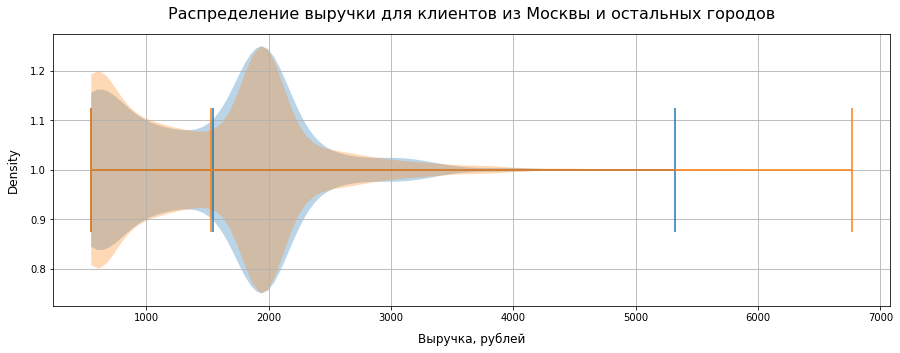

In [25]:
plt.figure(figsize=(15, 5))
plt.title('Распределение выручки для клиентов из Москвы и остальных городов', pad = 15, size = 16)
plt.xlabel('Выручка, рублей', labelpad = 10, size = 12)
plt.ylabel('Density', labelpad = 10, size = 12)
plt.violinplot(
    df[df['city'] == 'Москва']['income'], vert=False, showmeans=True
)
plt.violinplot(
    df[df['city'] != 'Москва']['income'], vert=False, showmeans=True
)     
plt.grid(which='both')
plt.show()

Несмотря на существенное отличие в размере выборок, распределения величин внутри выборок похожи. Максимум выше в выборке городов исключающих Москву, как и количество маленьких значений выручки. При этом в выборках практически совпадают средние.

Проверим гипотезу.

In [26]:
alpha = .05

results = st.ttest_ind(
    df[df['city'] == 'Москва']['income'], 
    df[df['city'] != 'Москва']['income'],
    equal_var = False
)

print('p-значение: ', results.pvalue)

if results.pvalue > alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5257376663729298
Отвергаем нулевую гипотезу


In [27]:
print('Средняя выручка по тарифу "Ultra" равна:', int(df[df['tariff'] == 'ultra']['income'].mean()), 'рублей.')
print('Средняя выручка по тарифу "Smart" равна:', int(df[df['tariff'] == 'smart']['income'].mean()), 'рублей.')
print('Средняя выручка по Москве равна:', int(df[df['city'] == 'Москва']['income'].mean()), 'рублей.')
print('Средняя выручка по остальным городам равна:', int(df[df['city'] != 'Москва']['income'].mean()), 'рублей.')

Средняя выручка по тарифу "Ultra" равна: 2070 рублей.
Средняя выручка по тарифу "Smart" равна: 1289 рублей.
Средняя выручка по Москве равна: 1546 рублей.
Средняя выручка по остальным городам равна: 1524 рублей.


### Вывод

Гипотеза о том что средняя выручка пользователей тарифов "Ультра" и "Смарт" различается подтвердилась. Так же это подтверждено средними значениями: 2070 и 1289 рублей в месяц соответственно.

Гипотеза о том что выручка пользователей из Москвы отличается от выручки пользователей из других регионов не подтвердилась. Средние значения вычисленные для генеральной совокупности для Москвы: 1546, для других регионов: 1524 рублей в месяц.

## Заключение<a id="step5"></a>

В ходе данной работы мы подготовили исходные данные:

    привели к нужным типам;
    исправили ошибки.
    
Для каждого пользователя посчитали:

    количество сделанных звонков и израсходованных минут разговора по месяцам;
    количество отправленных сообщений по месяцам;
    объем израсходованного интернет-трафика по месяцам;
    помесячную выручку.

При анализе поведения клиентов оператора мы заметили:

    в целом, пользователи тарифа "smart" часто пользуются услугами сверх нормы по тарифу, и наоборот, клиенты тарифа "ultra" редко выходят за лимиты.
    Среднее количество звонков больше на тарифе `ultra`.
    Средний доход почти в два раза выше на тарифе `ultra`.
    Количество смс также существенно отличается, почти в 2 раза больше на тарифе `ultra`.
    Средний траффик отличается незначительно по тарифам.

Мы проверили две гипотезы.

Гипотеза о том что средняя выручка пользователей тарифов "Ультра" и "Смарт" различается подтвердилась. Так же это подтверждено средними значениями: 2049.75 и 1172.97 рублей в месяц соответственно.

Гипотеза о том что выручка пользователей из Москвы отличается от выручки пользователей из других регионов не подтвердилась. Средние значения вычисленные для Москвы: 1466.27, для других регионов: 1435.90 рублей в месяц.

**Таким образом, по полученной выборке, можно сделать вывод о том, что несмотря на то что пользователи тарифа "Смарт" намного чаще пользуются услугами сверх лимитов, тариф "Ультра" выгоднее для компании "Мегалайн", т.к. при вдвое меньшем количестве пользователей приносит почти такой же доход как и тариф "Смарт".**